<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ознакомимся-с-данными" data-toc-modified-id="Ознакомимся-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ознакомимся с данными</a></span></li><li><span><a href="#Подготовка-текстов" data-toc-modified-id="Подготовка-текстов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка текстов</a></span></li><li><span><a href="#Векторизация-текстов" data-toc-modified-id="Векторизация-текстов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Векторизация текстов</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LDA</a></span><ul class="toc-item"><li><span><a href="#Ключевые-слова" data-toc-modified-id="Ключевые-слова-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ключевые слова</a></span></li><li><span><a href="#Типичные-статьи" data-toc-modified-id="Типичные-статьи-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Типичные статьи</a></span></li></ul></li><li><span><a href="#Модель-NMF" data-toc-modified-id="Модель-NMF-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Модель NMF</a></span><ul class="toc-item"><li><span><a href="#Ключевые-слова" data-toc-modified-id="Ключевые-слова-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Ключевые слова</a></span></li><li><span><a href="#Типичные-посты" data-toc-modified-id="Типичные-посты-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Типичные посты</a></span></li></ul></li></ul></div>

# Исследование темы наставничества в LinkedIn

**Описание проекта  и цель**

Требуется провести исследование по теме наставничества и менторства на основании контента социальной сети LinkedIn, размещенного в открытом доступе, созданного целевой аудиторией.

Задача исследования: определить топ-10 тем в направлении наставничества.

**Описание данных**

Сбор данных осуществлялся на сайт социальнй сети LinkedIn. В данных представлены ссылки на профили из ЦА (целевая аудитория), тексты публикаций. Некоторые тексты были написаны на иностранных языках, поэтому они были предварительно переведены на русский.

 - url_user - ссылка на профиль
 - text_post  - текст публикации
 - language  - язык публикации
 - translated_text - переведенный текст
 
 
 **План работы**
 
1. Предобработка данных
    - Ознакомление с данными
    - Подготовка текстов
    - Векторизация текстов
2. Моделирование
   - модель LDA
   - модель NMF
   - Ключевые слова для каждой модели
   - Типичные статьи для каждой модели
3. Выводы

# Предобработка данных

## Ознакомимся с данными

In [1]:
# Импорт библиотек
import re
import json
import warnings 

import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [2]:
warnings.filterwarnings('ignore')

In [7]:
# Ознакомимся с датасетом 
#df = pd.read_csv('data/all_data_translated.csv')
df = pd.read_csv(r'C:\Users\649\Yandex\Masterskaya\LI_Hackaton_4\LI_Hackaton_4\data\all_data_translated.csv')

# выведем первые строки
df.head(3)

,url_user,text_post,language,translated_text
0,https://www.linkedin.com/in/korenevich/,['Приложение которое из голоса раскидывает зад...,ru,['Приложение которое из голоса раскидывает зад...
1,https://www.linkedin.com/in/korenevich/,'Почему основатель любого бизнеса обязан умет...,ru,'Почему основатель любого бизнеса обязан умет...
2,https://www.linkedin.com/in/korenevich/,'Казнить нельзя помиловать. Навык #9 – принят...,ru,'Казнить нельзя помиловать. Навык #9 – принят...


Изначально данные собраны на разных языках. Дело в том, что рускоязычные спикеры пишут как на русском, там и на английском языках, поскольку социальная сеть предназначена для международной коммуникации в том числе.

In [8]:
# проверим размерность
df.shape

(11146, 4)

In [9]:
# Проверка на дубликаты
df.duplicated().sum()

211

In [10]:
# Удалим дубликаты 
df = df.drop_duplicates(keep='last')

In [11]:
# проверим пропуски
df.isna().sum()

url_user           0
text_post          0
language           0
translated_text    0
dtype: int64

In [12]:
# Проверим есть ли строки, в которых нет текста
df.loc[df['translated_text'] == '']

,url_user,text_post,language,translated_text


In [13]:
# Количество профилей
df.url_user.nunique()

1012

In [14]:
#посомотрим на итоговые результаты
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10935 entries, 0 to 11145
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url_user         10935 non-null  object
 1   text_post        10935 non-null  object
 2   language         10935 non-null  object
 3   translated_text  10935 non-null  object
dtypes: object(4)
memory usage: 427.1+ KB


In [15]:
# Посмотрим на тексты публикаций - случайным образом сэмплируем несколько примеров

df['translated_text'].sample(5)

861      'Всем привет! Делюсь радостной новостью: в но...
8103    Вы слышали о новой вредоносной программе? Иссл...
8099    «Facebook не может быть отключен, не так ли?»,...
8327    print('hello world!') В этом месяце Stack Over...
5880    Это был невероятный год во всех отношениях 🎄 В...
Name: translated_text, dtype: object

In [16]:
# Посмотрим какие языки присутсвуют в тексте
df['language'].unique()

array(['ru', 'ro', 'en', 'uk', 'hr', 'mk', 'ca', 'et', 'no', 'bg', 'fr',
       'sl', 'sq', 'fi', 'id', 'cs', 'it', 'af', 'tl', 'pt', 'sv', 'de',
       'es', 'nl', 'cy', 'da', 'sw', 'pl', 'tr', 'so', 'ar', 'lt', 'vi',
       'he', 'hu', 'sk'], dtype=object)

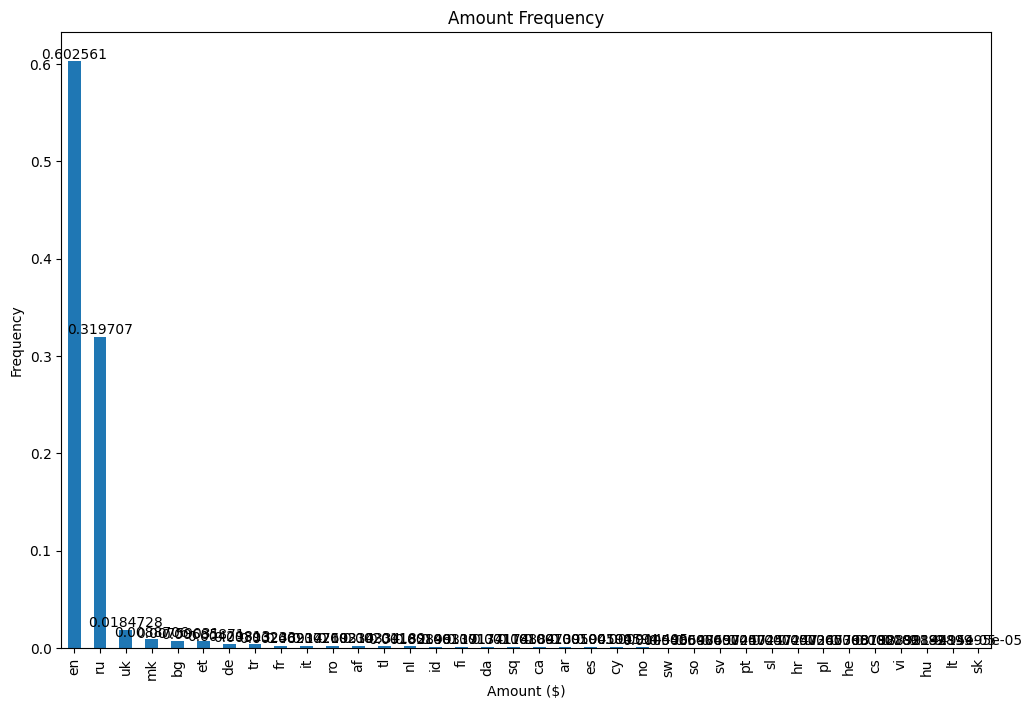

In [26]:
ax = df['language'].value_counts(normalize=True).plot(kind='bar', figsize=(12, 8), title='Amount Frequency',
             xlabel='Amount ($)', ylabel='Frequency', legend=False)

# annotate
ax.bar_label(ax.containers[0]);

# pad the spacing between the number and the edge of the figure
#ax.margins(y=0.1)

AttributeError: 'Series' object has no attribute 'patches'

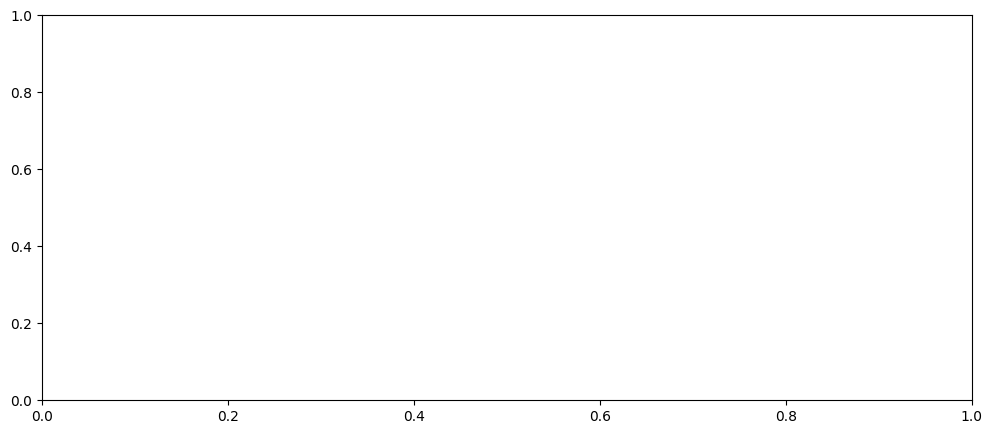

In [20]:
# Иследуем на каких языках написаны тексты
class_frequency = df['language'].value_counts(normalize=True)

plt.figure(figsize=(12,5))

plt.bar_label(container = class_frequency)
plt.title('Частота различных языков постов')
plt.xlabel('Язык')
plt.ylabel('Частота')


#print(class_frequency)

class_frequency.plot(kind='bar', color='lightblue');

Таким образом, подавляющее число постов написано на английском языке. Но данные были предварительно переведены в отдельном исследовании. Здесь используются уже данные полностью на русском языке. Посмотрим, какие именно тексты определились для других языков.


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

В относительно свежих версиях matplotlib есть метод [pyplot.bar_label](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar_label.html) – если сделать фигуру немного пошире, то можно добавить значения прямо на график и не выводить отдельную таблицу 👍

Или может быть объединить редкие языки в другое? 🤔
</div>


In [ ]:
#отфильтруем тексты
diff_lang = df.loc[(df['language']!='ru') & 
                   (df['language']!='en')]

len(diff_lang) 


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 

Еще один шаг в сторону оптимизации – [pandas.Series.isin](https://pandas.pydata.org/docs/reference/api/pandas.Series.isin.html), с ним можно сделать код еще проще

</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> 

В ячейке с кодом неожиданно фраза про "Язык отличный от английского и русского...", надо ее убрать в комментарий или вынести в текстовую ячейку markdown

</div>




Язык отличный от английского и русского встречается в достаточно большом количестве текстов. Под другими языками могли определиться тексты, содержащие хэштеги, профессионализмы и жаргон. Поскольку исходные данные были предварительно переведены, удалять языки, отличные от русского нет необходимости.


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b>

Надо перепроверить логику повествования – удаляем языки отличные от русского/английского или нет 🤔

Судя по коду – не удаляем. Тогда комментарий в ячейке с кодом лишний.

</div>

Далее проанализируем длинны текстов и, при необходимости, избавимся от коротких.

In [ ]:
# Добавим дополнительнй признак - длина текста
df['len_text'] = df['text_post'].apply(lambda x:len(x))

In [ ]:
# Построим гистограмму распределения длин
plt.figure(figsize=(10,6))
df['len_text'].plot.hist(bins = 30)

plt.title('Гистограмма распределения текстов по количеству символов')
plt.xlabel('Количество символов')
plt.show()


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

Очень хорошо что подкрепляешь выводы и находки иллюстрациями, графиками с подписанными осями, с заголовками 😉

</div>


In [ ]:
# выведем статистику по длиннам текстов
df['len_text'].describe()

Видно, что длина некоторых текстов достигает 6638 знаков, а минамальная длина равна двум знакам. Таким образом, 25% данных короче 110 символов. Посмотрим на примеры текстов и оценим несут ли они в себе полезную информацию.

In [ ]:
# Тексты короче 30 символов
df.loc[df['len_text'] < 30, 'translated_text']

In [ ]:
# Тексты короче 100 символов
df.loc[df['len_text'] < 100, 'translated_text']

Удалим тексты короче 100 символов. Предполагаем, что это как правило текст, который не несет нужной нас информации - это может быть подпись к картинке или видео, набор хэштэгов и пр.

In [ ]:
# Удалим наблюдения с текстами менее 100 символов
df_len_text_100 = df.loc[df['len_text'] > 100]


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Обоснованно 👍</div>


In [ ]:
# Количество наблюдений
len(df_len_text_100)

По завершению анализа исходных данных можно заключить:
   - размер датасета для анализа составляет **10935** строк на **4** столбцов. Представлены ссылки на профили пользователей, их имена, место работы, тексты публикаций и реакции на публикации;
   - пропусков в данных нет, но есть дубликаты;
   - текстах видны смайлы, хэштэги, служебные символы, слова и абревиатуры на английском, ссылки; 
   - тексты написаны на разных языках, количестов постов не на русском и не на английском языках - **850**;
   - выявлено, что **2506** текстов из **10935** "короткие" - т.е. их длина менее 100 символов. Из них 865 текстов короче 30 символов. Что составляет 23% и 8% от исходных данных.
   - максимальныя длина текста - 6638 символов.
   
   
На следующем этапе будут использоваться данные, где размерность текстов в постах составляет более 100 символов. Кроме того, тексты будут очищены от символов, смайлов и стоп-слов. 


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> 

Здесь немного непонятно откуда про имена, место работы и реакции на публикации. В представленном датасете этого нет. Если есть в исходниках – про это надо написать, где они , как обработаны и как получилось то что есть.

Ячейкой выше итоговый размер датасета 8413, а в тексте 10935 и даже выделено жирным шрифтом. Нарушена логическая последовательность – тогда уж удаление надо перенести ниже после этого вывода. Или выводы немного поправить. 


</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 

В целом хорошо, представлены разные аспекты данных, прокомментирован ход работы, раздел легко читается и действия понятны.

Есть некоторые замечания по описаниям и по коду, но они некритичные и надеюсь помогут улучшить работу 🤗
</div>


## Подготовка текстов

Далее проведем подготовку текстов: проведем лемматизацию и токенизацию текстов, а также очистим от "мусорных" символов.

In [ ]:
# определим модель spacy
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

In [ ]:
# Складываем все тексты в один список
texts = df_len_text_100["translated_text"].tolist()

In [ ]:
# Лемматизация текста для текстов, длиннее 100 символов
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    try:
        res.append([token.lemma_ for token in doc])
    except:
        print(doc)


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

Отлично – использование встроенного `nlp.pipe` 👍</div>


In [ ]:
# Сохраним результат лемматизации
with open("lemmas_100.json", "w") as fid:
    json.dump({"lemmas": res}, fid)

In [ ]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
for i in range(5):
    print(", ".join(res[np.random.randint(len(res))]))
    print()

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

И опять подсказка, как выбрать случайные образцы 😉

Со списками можно использовать [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) – и одной строчкой кода получить нужное количество примеров.
</div>


Удалим знаки препинания, цифры и слова, содержащие цифры. А также иностранные слова, которые не перевелись. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.

In [ ]:
# определим регулярное выражение
word_pattern = re.compile("^[а-я]*$")

In [ ]:
# определим функцию для очистки текста
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

In [ ]:
# очистим текст
corpus = list(map(remove_symbols, res))

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 

Здорово, что умеешь использовать регулярные выражения!

Кстати, для фильтрации в spacy можно использовать атрибуты токенов https://spacy.io/api/token#attributes и добавить проверку сразу на этапе лемматизации 🙃
</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> 

В регулярных выражениях для кириллицы надо «ё» добавлять, этот символ не по порядку расположен в кодировке 🧐

</div>


In [ ]:
# Определим как часто встречаются к корпусе пустые списки (удалены все слова)
corpus_empty = [li for li in corpus if len(li) < 1]
len(corpus_empty)

In [ ]:
# Смотрим на результат - случайным образом сэмплируем несколько примеров
for i in range(5):
    print(", ".join(corpus[np.random.randint(len(corpus))]))
    print()

Далее выведем облако слов для полученных лемм.

In [ ]:
# Зададим собственный список стоп-слов
stop_words_custom = ['это', 'наш', 'ваш', 'весь', 'это', 'наш', 'лс', 'свой', 'весь', 'год', 'якщо', 'дуже', 'ви', 
                     'але', 'роботи', 'буде', 'це', 'ми', 'як', 'що', 'хто', 'чи', 'цей', 'зараз', 'хто', 'чи', 'цей', 'час',
                    'мария', 'эй']

In [ ]:
# Дополнительные стоп-слова для руссковго языка
stop_words_additional = ["c","а","алло","без","белый","близко","более","больше","большой","будем","будет","будете","будешь",
                         "будто","буду","будут","будь","бы","бывает","бывь","был","была","были","было","быть","в","важная",
                         "важное","важные","важный","вам","вами","вас","ваш","ваша","ваше","ваши","вверх","вдали","вдруг",
                         "ведь","везде","вернуться","весь","вечер","взгляд","взять","вид","видел","видеть","вместе","вне",
                         "вниз","внизу","во","вода","война","вокруг","вон","вообще","вопрос","восемнадцатый","восемнадцать",
                         "восемь","восьмой","вот","впрочем","времени","время","все","все еще","всегда","всего","всем","всеми",
                         "всему","всех","всею","всю","всюду","вся","всё","второй","вы","выйти","г","где","главный","глаз",
                         "говорил","говорит","говорить","год","года","году","голова","голос","город","да","давать","давно",
                         "даже","далекий","далеко","дальше","даром","дать","два","двадцатый","двадцать","две","двенадцатый",
                         "двенадцать","дверь","двух","девятнадцатый","девятнадцать","девятый","девять","действительно","дел",
                         "делал","делать","делаю","дело","день","деньги","десятый","десять","для","до","довольно","долго",
                         "должен","должно","должный","дом","дорога","друг","другая","другие","других","друго","другое",
                         "другой","думать","душа","е","его","ее","ей","ему","если","есть","еще","ещё","ею","её","ж","ждать",
                         "же","жена","женщина","жизнь","жить","за","занят","занята","занято","заняты","затем","зато","зачем",
                         "здесь","земля","знать","значит","значить","и","иди","идти","из","или","им","имеет","имел","именно",
                         "иметь","ими","имя","иногда","их","к","каждая","каждое","каждые","каждый","кажется","казаться","как",
                         "какая","какой","кем","книга","когда","кого","ком","комната","кому","конец","конечно","которая",
                         "которого","которой","которые","который","которых","кроме","кругом","кто","куда","лежать","лет","ли",
                         "лицо","лишь","лучше","любить","люди","м","маленький","мало","мать","машина","между","меля","менее",
                         "меньше","меня","место","миллионов","мимо","минута","мир","мира","мне","много","многочисленная",
                         "многочисленное","многочисленные","многочисленный","мной","мною","мог","могу","могут","мож","может",
                         "может быть","можно","можхо","мои","мой","мор","москва","мочь","моя","моё","мы","на","наверху","над",
                         "надо","назад","наиболее","найти","наконец","нам","нами","народ","нас","начала","начать","наш","наша",
                         "наше","наши","не","него","недавно","недалеко","нее","ней","некоторый","нельзя","нем","немного",
                         "нему","непрерывно","нередко","несколько","нет","нею","неё","ни","нибудь","ниже","низко","никакой",
                         "никогда","никто","никуда","ним","ними","них","ничего","ничто","но","новый","нога","ночь","ну",
                         "нужно","нужный","нх","о","об","оба","обычно","один","одиннадцатый","одиннадцать","однажды",
                         "однако","одного","одной","оказаться","окно","около","он","она","они","оно","опять","особенно",
                         "остаться","от","ответить","отец","откуда","отовсюду","отсюда","очень","первый","перед","писать",
                         "плечо","по","под","подойди","подумать","пожалуйста","позже","пойти","пока","пол","получить",
                         "помнить","понимать","понять","пор","пора","после","последний","посмотреть","посреди","потом",
                         "потому","почему","почти","правда","прекрасно","при","про","просто","против","процентов","путь",
                         "пятнадцатый","пятнадцать","пятый","пять","работа","работать","раз","разве","рано","раньше",
                         "ребенок","решить","россия","рука","русский","ряд","рядом","с","с кем","сам","сама","сами","самим",
                         "самими","самих","само","самого","самой","самом","самому","саму","самый","свет","свое","своего",
                         "своей","свои","своих","свой","свою","сделать","сеаой","себе","себя","сегодня","седьмой","сейчас",
                         "семнадцатый","семнадцать","семь","сидеть","сила","сих","сказал","сказала","сказать","сколько",
                         "слишком","слово","случай","смотреть","сначала","снова","со","собой","собою","советский","совсем",
                         "спасибо","спросить","сразу","стал","старый","стать","стол","сторона","стоять","страна","суть",
                         "считать","т","та","так","такая","также","таки","такие","такое","такой","там","твои","твой","твоя",
                         "твоё","те","тебе","тебя","тем","теми","теперь","тех","то","тобой","тобою","товарищ","тогда","того",
                         "тоже","только","том","тому","тот","тою","третий","три","тринадцатый","тринадцать","ту","туда","тут",
                         "ты","тысяч","у","увидеть","уж","уже","улица","уметь","утро","хороший","хорошо","хотел бы","хотеть",
                         "хоть","хотя","хочешь","час","часто","часть","чаще","чего","человек","чем","чему","через","четвертый",
                         "четыре","четырнадцатый","четырнадцать","что","чтоб","чтобы","чуть","шестнадцатый","шестнадцать",
                         "шестой","шесть","эта","эти","этим","этими","этих","это","этого","этой","этом","этому","этот","эту",
                         "я","являюсь", "окоманюк", "леонардо", "силиконовый", "силиконовой", "чернобыль", "университетподать",
                        "щелчки", "постю", "ури", "мрт", "труха", "вооружиться", "пот", "запорожье", "айзека", "питерский", 
                         "ледовый", "подбираю", "топор", "капать", "правильном", "фотосессия"]

In [ ]:
# Объединим стоп-слова
stop_words = stopwords.words('russian') + stop_words_custom + stop_words_additional


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

Здорово, что ты умеешь работать с разными nlp модулями – и spacy, и nltk.

Но в данном случае, возможно, стоит взять за основу список стоп-стоп spacy? Он изначально включает в пять раз больше слов, чем nltk, его также можно расширить при необходимости. И используя атрибут `token.is_stop` можно фильтрацию сделать на этапе лемматизации 🤔

</div>


In [ ]:
#преобразуем столбец корпус в строку со всеми словами

list_corpus = []
for i in corpus:
    list_corpus.extend(i)
    
clean_corpus = list(set(list_corpus) - set(stop_words))

text_clean = ' '.join(clean_corpus)

#задаем параметры метода облака слов
cloud = WordCloud(max_words=50).generate(text_clean)

plt.figure(figsize=(10,6))
plt.imshow(cloud)
plt.axis('off')
None

Облако слов отобраджает самые популярные слова в представленных текстах. Таким образом, "менторинг" входит в топ 50.


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Красота! Особенно психбольница понравилась 😁 но из песни слово не выкинешь, все верно 👍</div>


## Векторизация текстов

Далее векторизируем полученный корпус. 

In [ ]:
# Посчитаем IDF всех наших слов, и отсечем слова с самым большим idf(очень редкие) и с самым маленьким
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

In [ ]:
# Объединим списки слов в предложения
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

In [ ]:
# трансформируем корпус
x = tfidf.fit_transform(docs)

In [ ]:
# проверим размерность
x.shape

In [ ]:
#сохраним id токенов
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Отлично 👍</div>


# Моделирование

## LDA

In [ ]:
# Зададим количество тем
n_topics = 10

In [ ]:
# определим модель
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=30,
                                random_state=31)

In [ ]:
# транформируем темы
topics = lda.fit_transform(x)

In [ ]:
# проверим размерность
topics.shape

Получили массив размера **8413x10**. Строки здесь - отдельные тексты, а колонки - 10 выделенных тем. В каждой ячейке стоит вероятность того, что данный текст относится к данной теме. 

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 👍</div>


### Ключевые слова

Далее выделем 10 ключевых слов для каждой темы.

In [ ]:
# выведем название темы и соотвествющие ключевые слова
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-10:]]
    print("Тема",i, ":")
    print(", ".join(topic_tokens))
    print("\n ")

По полученным ключевым словам можно составить представление о содержании той или иной темы.


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

Может, имеет смысл выводить слова топика в прямом порядке, а не в обратном? Чтобы первое слово самое топовое и потом по убыванию 🤔</div>


### Типичные статьи

Далее определим типичные посты для каждой темы.

In [ ]:
# циклом соеберм типычные посты по темам
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i)
    print(df_len_text_100.iloc[doc_id]["translated_text"])
    print("\n")

На основании полученных результатов можно предположить названия тем:
   - Тема 1 - проектное сотрудничество;
   - Тема 2 - внешняя политика;
   - Тема 3 - коучинг;
   - Тема 4 - предложение IT услуг; 
   - Тема 5 - менторство начинающих специалистов;
   - Тема 6 - новости IT рынка;
   - Тема 7 - обучение IT профессиям;
   - Тема 8 - IT рекрутмент;
   - Темы 9 и 10 также посвящены поиску работы.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

Отлично, собраны образцы постов и предложены названия тем 👍

Будет здорово, если нумерация тем будет совпадать с нумерацией постов 😉</div>


In [ ]:
# Добавим столбец с номером темы для каждого наблюдения
df_len_text_100['topic'] = topics.argmax(axis=1)

# посмотрим на результат
df_len_text_100.head()

In [ ]:
# Определим какие темы представлены чаще всего
df_len_text_100['topic'].value_counts()



<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>

Воооот, а чтобы не ломать голову что здесь обозначает 5 – на самом деле тема номер 6 из списка тем 😉 надо либо топики, либо темы перенумеровать.

Или можно сразу не номер, а название темы вписать в колонку 🤔
</div>


In [ ]:
# Добавим столбец с вероятностью принадлежности выбранной теме для каждого наблюдения
df_len_text_100['probability'] = topics.max(axis=1)

#посмотрим на результат
df_len_text_100.head()

In [ ]:
# Выберем топ-100 текстов с максимальной вероятностью
top_100 = (df_len_text_100[['translated_text', 'topic', 'probability']]
           .sort_values(by = 'probability', ascending  = False).iloc[:100])

#посмотрим на результат
top_100

На данном этапе выделили топ-100 постов с большей частотой встречающихся слов. Эти данные в дальнейшем могут использоваться для анализа целевой аудитории.

In [ ]:
# проверим, к каким темам относятся топ-100 текстов
top_100.topic.value_counts()

Алгоритм увереннее всего определяет пятую тему, что логично, так как именно эта тема представлена максимально (6440 текстов).

In [ ]:
# Попробуем оценить насколько уверен алгоритм в остальных темах
df_len_text_100.groupby('topic').agg({'probability' : 'mean', 
                                      'topic' : 'count'}).sort_values(by = 'probability', ascending = False)

Лучшие по средней вероятности темы - 5, 8, 6, не смотря на то, что 6 тема представлена только в 58 текстах. А вот 2, 1 и 0 темы определяются хуже всего. Вероятно, сказывается небольшое количество данных.


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 

Поскольку цель проекта все-таки не абстрактное тестирование моделей, уже очень хочется видеть не номера, а человекочитаемые названия тем 😉
</div>


Попробуем использовать распределения тем в тексте как 'эмбеддинги' текстов, в такой интерпретации можно применять к ним алгоритмы визуализации или кластеризации, и искать уже итоговые 'эффективные ' тематические кластеры таким образом.

In [ ]:
# определим количество кластеров
kmeans = KMeans(n_clusters=10)

#обучим модель
clust_labels = kmeans.fit_predict(topics)
clust_centers = kmeans.cluster_centers_

#объединим результат
embeddings_to_tsne = np.concatenate((topics,clust_centers), axis=0)

# TSNE это инструмент для визуализации многомерных данных
tSNE =  TSNE(n_components=2, perplexity=15)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [ ]:
#выделим кластеры
clust_indices = np.unique(clust_labels)

#далее определим параметры визуализации
clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
    
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

In [ ]:
#выведем полученный результат
plt.figure(figsize=(5,5))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

plt.show()

Тут хотелось бы написать, что на изображении tSNE ембеддингов, видно, что кластеры выделенные с помощью KMeans, образуют достаточно связные и чаще всего пространственно разделимые между собой множества. Но на самом деле видно, что есть над чем еще поработать.


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 👍</div>


## Модель NMF

In [ ]:
#определим количество тем
n_topics = 10

In [ ]:
#определим модель
nmf = NMF(n_components=n_topics,
          init = 'random',
          solver = 'mu',
          beta_loss = 'kullback-leibler',
          max_iter = 1000,
          shuffle = True,
          l1_ratio = 0.02,
          random_state=42)

In [ ]:
#трансформируем темы
topics_nmf = nmf.fit_transform(x)

In [ ]:
#посмотрим на результат
topics_nmf.shape

Таким образом, получен датасет, где для каждого текста определена вероятность принадлежности к определнным текстам.

### Ключевые слова

Далее выделем 15 ключевых слов для каждой темы.

In [ ]:
for i in range(n_topics):
    c = nmf.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-15:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

### Типичные посты

Далее определим типичные посты для каждой темы.

In [ ]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i+1)
    print(df_len_text_100.iloc[doc_id]["translated_text"])
    print("\n")

На основании полученных результатов можно предположить названия тем:
   - Тема 1 - проектное сотрудничество;
   - Тема 2 - лайфхаки при поиске работы;
   - Тема 3 - образовательные статьи;
   - Тема 4 - нетворкинг/поиск сотрудника; 
   - Тема 5 - внешняя политика;
   - Тема 6 - разработка/кодинг;
   - Тема 7 - кейсы компаний/дизайн;
   - Тема 8 - рекрутмент;
   - Тема 9 - релокация;
   - Тема 10 - менторство начинающих специалистов.

In [ ]:
# Добавим столбец с номером темы для каждого наблюдения
df_len_text_100['topic_nmf'] = topics_nmf.argmax(axis=1)

In [ ]:
# Определим какие темы представлены чаще всего
df_len_text_100['topic_nmf'].value_counts()

In [ ]:
# Добавим столбец с вероятностью принадлежности выбранной теме для каждого наблюдения
df_len_text_100['probability_nmf'] = topics_nmf.max(axis=1)

#посмотрим на результат
df_len_text_100.head()

Выделим также топ-100 текстов, которые нашла вторая модель.

In [ ]:
# Выберем топ-100 текстов с максимальной вероятностью
top_100_nmf = (df_len_text_100[['translated_text', 'topic_nmf', 'probability_nmf']]
           .sort_values(by = 'probability_nmf', ascending  = False).iloc[:100])

#посмотрим на результат
top_100_nmf

In [ ]:
# проверим, к каким темам относятся топ-100 текстов
top_100_nmf.topic_nmf.value_counts()

Тексты распределились достаточно рамномерно. Самые частые темы - 2 и 4.


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Интересно, а что это за темы? 🤔</div>


In [ ]:
# Попробуем оценить насколько уверен алгоритм в остальных темах
df_len_text_100.groupby('topic_nmf').agg({'probability_nmf' : 'mean', 
                                      'topic_nmf' : 'count'}).sort_values(by = 'probability_nmf', ascending = False)

Вероятности распределились равномерно по всем темам. Можно заметить, что данная модель плохо разделила тексты по темам, вероятность везде достаточно низкая. Можно предположить, что гиперпараметры были настроены не совсем удачно. Кроме того, похоже что имеющиеся данные в целом не кардинально отличаются друг от друга по содержанию.

In [ ]:
# определим количество кластеров
kmeans2 = KMeans(n_clusters=10)

#обучим модель
clust_labels2 = kmeans2.fit_predict(topics)
clust_centers2 = kmeans2.cluster_centers_

#объединим результат
embeddings_to_tsne2 = np.concatenate((topics_nmf,clust_centers2), axis=0)

# TSNE это инструмент для визуализации многомерных данных
tSNE_nmf =  TSNE(n_components=2, perplexity=15)
tsne_embeddings2 = tSNE_nmf.fit_transform(embeddings_to_tsne2)
tsne_embeddings2, centroids_embeddings2 = np.split(tsne_embeddings2, [len(clust_labels2)], axis=0)

In [ ]:
#выделим кластеры
clust_indices2 = np.unique(clust_labels2)

#далее определим параметры визуализации
clusters2 = {clust_ind : [] for clust_ind in clust_indices2}
for emb, label in zip(tsne_embeddings2, clust_labels2):
    clusters2[label].append(emb)

for key in clusters2.keys():
    clusters2[key] = np.array(clusters2[key])
    
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices2)))

In [ ]:
#выведем полученный результат
plt.figure(figsize=(5,5))
for ind, color in zip(clust_indices2, colors):
    x = clusters2[ind][:,0]
    y = clusters2[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid2 = centroids_embeddings2[ind]
    plt.scatter(centroid2[0],centroid2[1], color=color, marker='x', s=100)

plt.show()

Визуализация явно показывает, что модель NMF с использованными гиперпараметрами не справляется со своей задачей.


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b>

Повторяющийся громоздкий код можно упаковать в функцию 😉

</div>


# Выводы

Для проведения исследования командой написан скрипт (parser) для сбора данных в социальной сети LinkedIN, которые представляют собой ссылки на профили людей, подходящих под ЦА заказчика, тексты их постов и реакции.

Получилось собрать информацию о 158 профилях и 1125 текстов. Преобладающее количество текстов на русском языке. Но из-за небольшого их количества выполнить задачу не представлялось возможным. Поэтому, для улучшения качества прогноза модели, было решено обменяться собранными данными с другими командами.

**В итоге, для анализе использовались 1012 профилей и 11146 текстов.** Полученные тексты распределились по языкам следующим образом:
 - en - 60%
 - ru - 32%
 - uk - 2%
 - остальные - 6% (всего определлились 36 языков).

Для корректного анализа тексты предварительно переведены на русский язык.

При исследовании длин полученных текстов установлено, что максимальная достигает 6638 знаков, а минимальная длина равна двум знакам. Таким образом, 25% собранных данных короче 110 символов. Такие "короткие" тексты (предположительно подпись к картинке или видео, набор хэштэгов, смайлов и пр.) не несли в себе полезную информацию, поэтому решено удалить эти наблюдения. В итоге использовались 8413 текстов.

На этапе подготовки текстов для модели была проведена лемматизация и токенизация текстов. Также тексты были очищены от "мусорных" символов - знаков пунктуации, смайлов, иностранных слов, цифр. Удалены стоп-слова. 

Векторизация текстов производилась при помощи Tf-iDf.
На этапе подбора модели были использованы:
 - LDA - LatentDirichletAllocation
 - NMF - Non-Negative Matrix Factorization

Эффективность работы модели сложно оценить, так как нет метрик на которые можно опереться. Для выбора модели использовали здравый смысл и алгоритмы визуализации, которые позволили определить насколько хорошо модель разделяет тесты по темам.

Корректное распределение вероятности и лучшее разделение тем получено в результате применения модели LDA. Таким образом, рейтинг тем на основании частоты упоминания в порядке убывания:

 - Тема 6 - новости IT рынка;
 - Тема 9 - поиск работы;
 - Тема 7 - обучение IT профессиям;
 - Тема 4 - предложение IT услуг;
 - Тема 8 - IT рекрутмент;
 - Тема 10 - поиск работы;
 - Тема 5 - менторство начинающих специалистов;
 - Тема 3 - коучинг;
 - Тема 2 - внешняя политика;
 - Тема 1 - проектное сотрудничество;
 
Выделены следующие топ-10 ключевых слов по темам:

| Тема | Название темы | Количество тем |Средняя вероятность | Ключевые слова |
|----------|----------|----------|----------|----------|
| Тема 6    | новости IT рынка   | 6440 | 0.75 | решение, опыт, клиент, приложение, продукт, бизнес, разработка, команда, проект, компания |
| Тема 9    | поиск работы   | 206 | 0.71 | кибербезопасность, здравствовать, признателен, иб, поддержка, совет, предложить, возможность, заранее, благодарить |
| Тема 7    | обучение IT профессиям   | 58 | 0.66 | асинхронный, машинный, буква, испытание, карусель, видео, генеративный, проверить, курс, закончить |
| Тема 4    | предложение IT услуг   | 186 | 0.65 | рад, услуга, разработка, сообщить, сертификат, компания, должность, начинать, удовольствие, сообщать |
| Тема 8    | IT рекрутмент   | 128 | 0.63 | делиться, статья, желать, тильда, оценить, комментарий, праздник, ребята, нанимать, лендинг |
| Тема 10   | поиск работы    | 180 | 0.63 | встретиться, отличный, нетерпение, невероятный, поделиться, грузия, команда, заявка, рад, саммит |
| Тема 5    | менторство начинающих специалистов   | 611 | 0.61 | английский, команда, поиск, проект, привет, опыт, резюме, разработчик, искать, вакансия |
| Тема 3    | коучинг   | 151 | 0.60 | желать, счастливый, выходной, справляться, проверка, пройти, тест, следующий, значок, навык |
| Тема 2    | внешняя политика   | 262 | 0.57 | военный, европа, доклад, вебинар, ноябрь, март, российский, конференция, украинец, украина |
| Тема 1    | проектное сотрудничество   | 191 | 0.56 | создать, фирменный, анимация, пожаловать, сайт, добро, дизайнер, стиль, логотип, дизайн |

На основании полученных результатов можно заметить, что все посты написаны примерно про одно и то же, это: поиск работы или работников, впечатление от обучения и несколько тем посвящены коучингу и менторству начинающих специалистов. По теме наставничества целевая группа пишет немного.

**Пример визуализации разделения тем на кластеры моделью LDA**
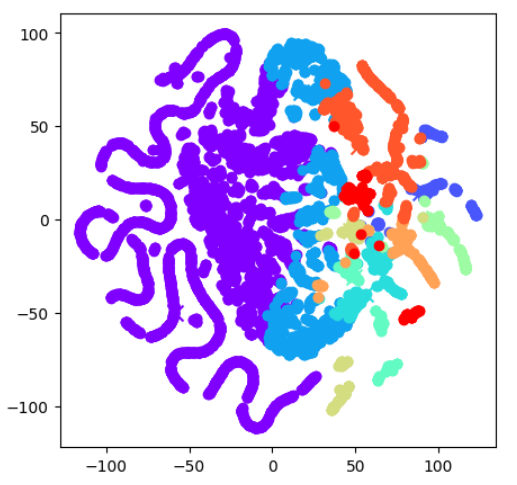
На изображении tSNE ембеддингов, видно, что кластеры выделенные с помощью KMeans, образуют достаточно связные и чаще всего пространственно разделимые между собой множества. Но так же видно, что есть над чем еще поработать.

При анализе распределения тем, с большим отрывом лидирует тема 6 (6440 текстов), на втором месте модель поставила тему 5 - 611 текстов, на третьем - 2 тема и 262 текста.

При оценке топ-100 постов, для которых модель наиболее уверенно (с большей вероятностью) определила тему выяснилось, что все эти посты отнесены к теме 6. Что логично, так как эти тексты представлены на порядок в большем количестве. Вероятность для топ-100 находится в пределах 0.92 - 0.89.

При оценке средней вероятности, с которой алгоритм определял принадлежность к определенной теме выяснилось, что увереннее всего он справляется с темами:
 - 6 тема - средняя вероятность 0.75 - количество текстов 6440
 - 9 тема - средняя вероятность 0.71 - количество текстов 206
 - 7 тема - средняя вероятность 0.66 - количество текстов 58

Хуже всего модель справилась с темами 3, 2 и 1 - средние вероятности 0.60 (151 текст), 0.57(262) и 0.56(191). Возможно, это связано с тебольшим количеством текстов для данных тем.

Стоит отметить, что данные пришедшие от других команд, содержат значительное количество текстов на политичесие темы, что не относится к теме исследования. В дальнейшем планируется вычислить датасет с нерелевантными данными и исключить его из моделирования.


**Что можно сделать лучше:**
- Изменить стратегию поиска постов, применить другие ключевые слова для сбора данных целевой аудитории.
- Хороший результат был получен при добавлении стоп кастомизированных стоп-слов, расширение этого списка потенциально может улучшить работу модели.
- Попробовать использовать предобученные модели BERT как самостоятельный вариант или вместе с LDA.


**В ходе работы над проектом команда столкнулась со следующими сложностями:**
   - замена ключевого участника на середине хакатона;
   - социальная сеть LinkdIn хорошо защищает данные своих пользователей от парсинга. Кроме того, накладывает ограничения на возможность просмотра профилей - пользователи с маленьким количеством контактов не могут просмотривать посты других людей. Проблема была решена путем обмена контактами участников хакатона друг с другом и объединением всех собранных данных команд в один датасет.
   - некоторые посты отдельных пользователей защищены от парсинга, в связи с этим, возникла проблема с корректным сбором реакций на посты. Проблема пока остается не решенной, однако это не мешает тематическому моделированию и получению достоверных результатов;
   - оказалось, что представители целевой аудитории мало пишут про наставничество и менторство. В связи с этим возникла проблема нехватки данных по теме исследования хакатона. Проблема может быть решена более тщательным подбором ключевых слов для фильтрации пользователей.

<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b>

К сожалению, выполнена только часть работы по сбору топиков и ключевых слов написанных постов.

- Не раскрыта тема, а что парсили и по каким критериям?
- Нет анализа популярности этих тем по реакциям читателей
- Нет анализа аудитории
</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b>

Судя по тому какая обработка в collect_parsed_data потребовалась для объединения собственных данных парсинга – структура датасета для сохранения была очень неоптимальной. Циклы split, append – вероятно там были списки? Список из типа object можно обратно в список преобразовать через [eval](https://docs.python.org/3/library/functions.html#eval) либо в парсере сразу все структурировать.

- В парсере строки 62 и 63 – получается парсинг выполняется дважды, чтобы собрать посты и потом чтоб собрать лайки.
- При этом лайки насколько я понимаю не стали разделять по постам, а просто сложили в общий список для каждого юзера?
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> В целом проведена большая работа. Код читаемый, аккуратный. К каждому шагу есть пояснения. Видно, что технически ты хорошо владеешь инструментом 👍</div>
